# Imports and variable setup

In [1]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import plotly.express as px
import pandas as pd
import numpy as np
import os

import datetime 

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils import filter_by_rule, detect_outliers_z_score, report_results, run_dbscan, \
    get_kdist_plot, dbscan_predict, calculate_adjusted_density
from config import *
import pickle


import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning))

from DSClassifierMultiQ import DSClassifierMultiQ



c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging


if not os.path.exists("logs"):
    os.mkdir("logs")

log_file = os.path.join("logs", "api.log")

rfh = logging.handlers.RotatingFileHandler(
    filename=log_file,
    mode='a',
    maxBytes=LOGGING_MAX_SIZE_MB*1024*1024,
    backupCount=LOGGING_BACKUP_COUNT,
    encoding=None,
    delay=0
)

logging.getLogger('matplotlib.font_manager').disabled = True

console_handler = logging.StreamHandler()

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%y-%m-%d %H:%M:%S",
    handlers=[
        rfh,
        console_handler
    ],
)

logger = logging.getLogger(__name__)

In [3]:
#  https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor/data
DATASET_FOLDER = "datasets" 

assert os.path.exists(DATASET_FOLDER), "Dataset folder not found"

datasets = os.listdir(DATASET_FOLDER)
logging.info(f"Found {len(datasets)} datasets")

24-04-27 19:58:57 [INFO] Found 2 datasets


# Reading the data

## Load the dataset, make checks

In [4]:
dataset = datasets[1]
dataset_name = dataset.split(".")[0]

data = pd.read_csv(os.path.join(DATASET_FOLDER, dataset)).head(2000)

logger.debug(f"Dataset: {dataset_name} | Shape: {data.shape}")
# if missing more than 20% of the data, drop the column
missing_threshold = 0.2
data = data.dropna(thresh=len(data) * (1 - missing_threshold), axis=1)
logger.debug(f"{data.shape} droped columns with more than {missing_threshold*100:.0f}% missing values")
# drop rows with missing values
data = data.dropna()
logger.debug(f"{data.shape} drop rows with missing values")

assert data.isna().sum().sum() == 0, "Dataset contains missing values"
assert "labels" in data.columns, "Dataset does not contain `labels` column"
assert data.labels.nunique() == 2, "Dataset labels are not binary"

label_ratio = data.labels.value_counts(normalize=True).iloc[0]
assert 0.4 < label_ratio < 0.6, "Label ratio is not balanced"


# leave only numeric columns
data = data.select_dtypes(include=[np.number])
logger.debug(f"{data.shape} drop non-numeric columns")

# move labels column to the end 
data = data[[col for col in data.columns if col != "labels"] + ["labels"]]

logging.info(f"------ Dataset: {dataset_name} | Shape: {data.shape} | Label ratio: {label_ratio:.2f} -------")

24-04-27 19:58:58 [DEBUG] Dataset: Telecom_customer churn | Shape: (2000, 99)
24-04-27 19:58:58 [DEBUG] (2000, 93) droped columns with more than 20% missing values
24-04-27 19:58:58 [DEBUG] (1543, 93) drop rows with missing values
24-04-27 19:58:58 [DEBUG] (1543, 77) drop non-numeric columns
24-04-27 19:58:58 [INFO] ------ Dataset: Telecom_customer churn | Shape: (1543, 77) | Label ratio: 0.52 -------


## Train test split

In [5]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data = data.apply(pd.to_numeric)
cut = int(train_set_size*len(data))

train_data_df = data.iloc[:cut]
test_data_df = data.iloc[cut:]

X_train = data.iloc[:cut, :-1].values
y_train = data.iloc[:cut, -1].values
X_test = data.iloc[cut:, :-1].values
y_test = data.iloc[cut:, -1].values

logging.info(f"Step 0: Data split done | {len(X_train)} - {len(X_test)}")


24-04-27 19:58:58 [INFO] Step 0: Data split done | 1080 - 463


## Scaling

In [6]:
st_scaler = StandardScaler().fit(train_data_df)
# break
scale = st_scaler.scale_
mean = st_scaler.mean_
var = st_scaler.var_ 

X_train_scaled = st_scaler.transform(train_data_df)
X_test_scaled = st_scaler.transform(test_data_df)  #! during inference we won't have this

logging.debug("Step 1: Standard scaling complete")

24-04-27 19:58:58 [DEBUG] Step 1: Standard scaling complete


## Clustering

### Fitting and Inference

In [7]:

CLUSTERING_ALG = "dbscan" # in future we'll add DBSCAN
# CLUSTERING_ALG = "kmeans" # in future we'll add DBSCAN

logging.info(f"Step 2.1: Performing {CLUSTERING_ALG} clustering")



if CLUSTERING_ALG == "kmeans":
    clustering_model = KMeans(n_clusters=2, random_state=42, n_init="auto")      
    clustering_model.fit(X_train_scaled)  
    
    clustering_labels_train = clustering_model.predict(X_train_scaled)
    clustering_labels_test = clustering_model.predict(X_test_scaled)
else:
    clustering_model = run_dbscan(X_train_scaled, eps=0.01, max_eps=20, min_samples=2, step=0.05) #*X_train.shape[1] - 1)
    if clustering_model is None:
        logging.warning(f"Could not find the desired number of clusters for {dataset_name}")
        raise Exception("Clustering failed")
    
    clustering_labels_train = dbscan_predict(clustering_model, X_train_scaled)
    clustering_labels_test = dbscan_predict(clustering_model, X_test_scaled)
    
    db_eps = clustering_model.eps
    


train_data_df["labels_clustering"] = clustering_labels_train
test_data_df["labels_clustering"] = clustering_labels_test

logger.info(f"Step 2.1: Clustering and inference done")

24-04-27 19:58:58 [INFO] Step 2.1: Performing dbscan clustering
Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\hayk_\.conda\envs\thesis\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\hayk_\.conda\envs\thesis\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\hayk_\.conda\envs\thesis\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\hayk_\.conda\envs\thesis\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can si

Found the desired number of clusters: 2 at eps=7.95999999999998


24-04-27 19:59:02 [INFO] Step 2.1: Clustering and inference done


## Evaluation (silhouette, ...)

In [8]:

def evaluate_clustering(df, labels, model=None, alg="kmeans", round_digits=3, 
                        print_results=False, dataset="train"):
    silhouette = silhouette_score(df, labels).round(round_digits)
    calinski_harabasz = calinski_harabasz_score(df, labels).round(round_digits)
    
    if alg == "kmeans" and dataset=="train":
        inertia = round(model.inertia_,round_digits)
        
    
    if print_results:
        logging.debug(f"Evaluation on {dataset}")
        logging.debug(f"\t{silhouette = }")
        logging.debug(f"\t{calinski_harabasz = }")
        if alg == "kmeans" and dataset=="train":
            logging.debug(f"\t{inertia = }")
    
evaluate_clustering(X_train_scaled, clustering_labels_train, clustering_model, 
                    CLUSTERING_ALG, print_results=True)
evaluate_clustering(X_test_scaled, clustering_labels_test, clustering_model, 
                    CLUSTERING_ALG, print_results=True, dataset="test")

logging.info("Step 2.2: Clustering evaluation done")

24-04-27 19:59:02 [DEBUG] Evaluation on train
24-04-27 19:59:02 [DEBUG] 	silhouette = 0.46
24-04-27 19:59:02 [DEBUG] 	calinski_harabasz = 127.522
24-04-27 19:59:02 [DEBUG] Evaluation on test
24-04-27 19:59:02 [DEBUG] 	silhouette = 0.567
24-04-27 19:59:02 [DEBUG] 	calinski_harabasz = 139.743
24-04-27 19:59:02 [INFO] Step 2.2: Clustering evaluation done


## Clustering evaluation (as pseudo clsassifier)

In [9]:

def evaluate_classifier(*, y_actual, y_clust, dataset="train", print_results=False,
                        purpose="kmeans_eval"):    
    TP = sum((y_actual == 1) & (y_clust == 1))
    TN = sum((y_actual == 0) & (y_clust == 0))
    accuracy = (TP + TN) / len(y_actual)
    if purpose == "kmeans_eval":
        if accuracy < 0.5: # swap 1's and 0's
            y_clust = np.array([1 if label == 0 else 0 for label in y_clust])

    TP = sum((y_actual == 1) & (y_clust == 1))
    TN = sum((y_actual == 0) & (y_clust == 0))
    FP = sum((y_actual == 0) & (y_clust == 1))
    FN = sum((y_actual == 1) & (y_clust == 0))

    accuracy = (TP + TN) / len(y_actual)
    f1 = TP / (TP + 0.5 * (FP + FN))
    conf_matrix = np.array([[TN, FP], [FN, TP]])
    # f1 = f1_score(y_actual, y_clust)
    # conf_matrix = confusion_matrix(y_actual, y_clust)
    
    if print_results:
        logging.debug(f"Evaluation on {dataset}")
        logging.debug(f"\tAccuracy:  {accuracy:.2f}")
        logging.debug(f"\tF1 Score: {f1:.2f}")
        logging.debug(f"\tConfusion Matrix: \n{conf_matrix}")
    
    return {"accuracy": accuracy, "f1": f1, "confusion_matrix": conf_matrix}

In [10]:
evaluate_classifier(y_actual=y_train, y_clust=clustering_labels_train, 
                    dataset="train", print_results=True)
evaluate_classifier(y_actual=y_test, y_clust=clustering_labels_test, 
                    dataset="test", print_results=True)

logger.info("Step 3: Clustering as a classifier, evaluation done")

24-04-27 19:59:02 [DEBUG] Evaluation on train
24-04-27 19:59:02 [DEBUG] 	Accuracy:  0.51
24-04-27 19:59:02 [DEBUG] 	F1 Score: 0.65
24-04-27 19:59:02 [DEBUG] 	Confusion Matrix: 
[[ 66 487]
 [ 38 489]]
24-04-27 19:59:02 [DEBUG] Evaluation on test
24-04-27 19:59:02 [DEBUG] 	Accuracy:  0.51
24-04-27 19:59:02 [DEBUG] 	F1 Score: 0.64
24-04-27 19:59:02 [DEBUG] 	Confusion Matrix: 
[[ 33 213]
 [ 16 201]]
24-04-27 19:59:02 [INFO] Step 3: Clustering as a classifier, evaluation done


## Distance calculation

In [11]:
def get_distance(df, model, alg="kmeans", density_radius=0.5):
    if alg == "kmeans":
        distances = np.min(
            np.linalg.norm(df[:, np.newaxis] - model.cluster_centers_, axis=2), axis=1) 
    else:
        distances= calculate_adjusted_density(df, model.labels_, radius=density_radius, 
                                              penalty_rate=penalty_rate, 
                                              remove_outliers=False, normalize=False)
    
    return distances
    

In [12]:
def remove_outliers_and_normalize(df, distance_column="distance", label_column="labels"):    
    outliers = detect_outliers_z_score(df["distance"])
    df["outlier"] = df[distance_column].apply(lambda x: x in outliers)
    df_no_outliers = df[~df["outlier"]]
    
    # min max scale the df. dont use outliers
    min_val = df_no_outliers.groupby(label_column)[distance_column].apply('min')
    max_val = df_no_outliers.groupby(label_column)[distance_column].apply('max')
    
    def scale(x, label):
        return (x - min_val[label]) / (max_val[label] - min_val[label]) if max_val[label] > min_val[label] else 0
        
    dist_norm = df.apply(lambda row: scale(row[distance_column], row[label_column]), axis=1)
    
    return dist_norm

In [13]:
db_eps

7.95999999999998

In [14]:
train_data_df["distance"] = get_distance(X_train_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)
test_data_df["distance"] = get_distance(X_test_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)

In [15]:
train_data_df["distance_norm"] = remove_outliers_and_normalize(train_data_df, label_column="labels_clustering") 
test_data_df["distance_norm"] = remove_outliers_and_normalize(test_data_df, label_column="labels_clustering")

assert train_data_df.isna().sum().sum() == 0, "Train data contains NaNs"
assert test_data_df.isna().sum().sum() == 0, "Train data contains NaNs"

logger.info(f"Step 4: Distance calculation done")

24-04-27 19:59:03 [INFO] Step 4: Distance calculation done


## DST

In [17]:
# !pip install -U kaleido
print(1)

1


24-04-27 19:59:05 [DEBUG] Train: 1080
24-04-27 19:59:05 [INFO] Step 5: Run DST (igonre this dataset=Telecom_customer churn, clust=dbscan breaks=3, add_mult_rules=False, maf_method=clustering)
24-04-27 19:59:05 [DEBUG] 	Model init done
24-04-27 19:59:05 [DEBUG] Number of data points left after filtering: 262
24-04-27 19:59:05 [DEBUG] Number of clusters left after filtering: 2
24-04-27 19:59:05 [DEBUG] Most common cluster: 1
24-04-27 19:59:05 [DEBUG] Data points belong to different clusters
24-04-27 19:59:05 [DEBUG] Confidence: 0.21651189312479646
24-04-27 19:59:05 [DEBUG] Confidence after lowering based on proportion: 0.5364860436425323
24-04-27 19:59:06 [DEBUG] Number of data points left after filtering: 417
24-04-27 19:59:06 [DEBUG] Number of clusters left after filtering: 2
24-04-27 19:59:06 [DEBUG] Most common cluster: 0
24-04-27 19:59:06 [DEBUG] Data points belong to different clusters
24-04-27 19:59:06 [DEBUG] Confidence: 0.2417010480390761
24-04-27 19:59:06 [DEBUG] Confidence aft

Optimization started
Processing epoch	9	0.3493	

24-04-27 19:59:45 [DEBUG] 	Model fit done



Training time: 8.65s, epochs: 9

Least training loss reached: 0.352
DSModelMultiQ(
  DS Classifier using 302 rules
  
  Rule 1: rev_Mean < 32.278
  	C1: 0.191	C2: 0.571	Unc: 0.238
  
  Rule 2: 32.278 < rev_Mean < 67.108
  	C1: 0.570	C2: 0.233	Unc: 0.197
  
  Rule 3: 67.108 < rev_Mean < 101.937
  	C1: 0.745	C2: 0.116	Unc: 0.139
  
  Rule 4: rev_Mean > 101.937
  	C1: 0.934	C2: 0.020	Unc: 0.046
  
  Rule 5: mou_Mean < 137.502
  	C1: 0.194	C2: 0.563	Unc: 0.243
  
  Rule 6: 137.502 < mou_Mean < 588.828
  	C1: 0.157	C2: 0.606	Unc: 0.237
  
  Rule 7: 588.828 < mou_Mean < 1040.153
  	C1: 0.725	C2: 0.116	Unc: 0.159
  
  Rule 8: mou_Mean > 1040.153
  	C1: 0.949	C2: 0.014	Unc: 0.037
  
  Rule 9: totmrc_Mean < 29.970
  	C1: 0.181	C2: 0.569	Unc: 0.250
  
  Rule 10: 29.970 < totmrc_Mean < 51.264
  	C1: 0.151	C2: 0.655	Unc: 0.194
  
  Rule 11: 51.264 < totmrc_Mean < 72.558
  	C1: 0.674	C2: 0.184	Unc: 0.143
  
  Rule 12: totmrc_Mean > 72.558
  	C1: 0.870	C2: 0.055	Unc: 0.075
  
  Rule 13: da_Mean < -

24-04-27 19:59:46 [INFO] Step 6: Inference done
24-04-27 19:59:46 [DEBUG] Training Time: 8.65s
24-04-27 19:59:46 [DEBUG] Epochs: 9
24-04-27 19:59:46 [DEBUG] Min Loss: 0.352
24-04-27 19:59:46 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
24-04-27 19:59:46 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.


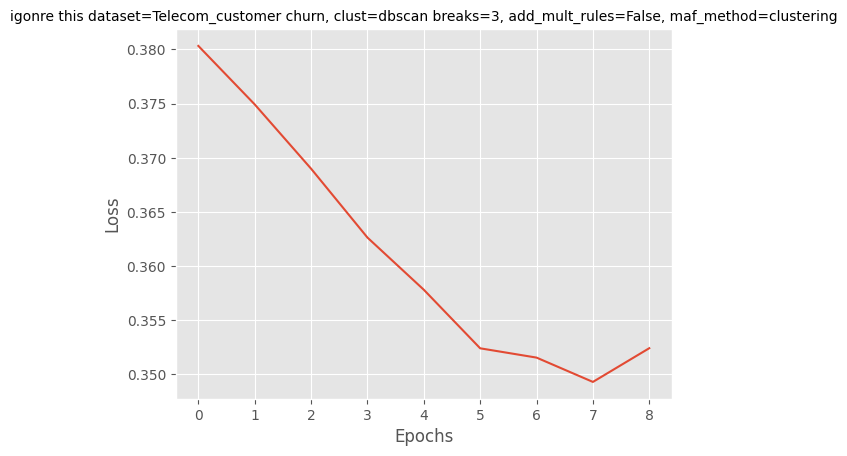

24-04-27 19:59:48 [DEBUG] Accuracy:  0.57
24-04-27 19:59:48 [DEBUG] F1 Score: 0.37
24-04-27 19:59:48 [DEBUG] Confusion Matrix: 
[[204  42]
 [159  58]]
24-04-27 19:59:48 [INFO] ------------------------------
24-04-27 19:59:48 [INFO] Step 5: Run DST (igonre this dataset=Telecom_customer churn, clust=dbscan breaks=3, add_mult_rules=False, maf_method=random)
24-04-27 19:59:48 [DEBUG] 	Model init done


Optimization started
Processing epoch	4	0.2784	

24-04-27 19:59:57 [DEBUG] 	Model fit done



Training time: 9.46s, epochs: 4

Least training loss reached: 0.281
DSModelMultiQ(
  DS Classifier using 302 rules
  
  Rule 1: rev_Mean < 32.278
  	C1: 0.138	C2: 0.058	Unc: 0.804
  
  Rule 2: 32.278 < rev_Mean < 67.108
  	C1: 0.109	C2: 0.089	Unc: 0.802
  
  Rule 3: 67.108 < rev_Mean < 101.937
  	C1: 0.082	C2: 0.117	Unc: 0.801
  
  Rule 4: rev_Mean > 101.937
  	C1: 0.180	C2: 0.018	Unc: 0.802
  
  Rule 5: mou_Mean < 137.502
  	C1: 0.087	C2: 0.110	Unc: 0.803
  
  Rule 6: 137.502 < mou_Mean < 588.828
  	C1: 0.086	C2: 0.113	Unc: 0.801
  
  Rule 7: 588.828 < mou_Mean < 1040.153
  	C1: 0.109	C2: 0.089	Unc: 0.802
  
  Rule 8: mou_Mean > 1040.153
  	C1: 0.100	C2: 0.097	Unc: 0.803
  
  Rule 9: totmrc_Mean < 29.970
  	C1: 0.086	C2: 0.112	Unc: 0.802
  
  Rule 10: 29.970 < totmrc_Mean < 51.264
  	C1: 0.161	C2: 0.036	Unc: 0.802
  
  Rule 11: 51.264 < totmrc_Mean < 72.558
  	C1: 0.161	C2: 0.037	Unc: 0.802
  
  Rule 12: totmrc_Mean > 72.558
  	C1: 0.073	C2: 0.125	Unc: 0.801
  
  Rule 13: da_Mean < -

24-04-27 19:59:59 [INFO] Step 6: Inference done
24-04-27 19:59:59 [DEBUG] Training Time: 9.46s
24-04-27 19:59:59 [DEBUG] Epochs: 4
24-04-27 19:59:59 [DEBUG] Min Loss: 0.281


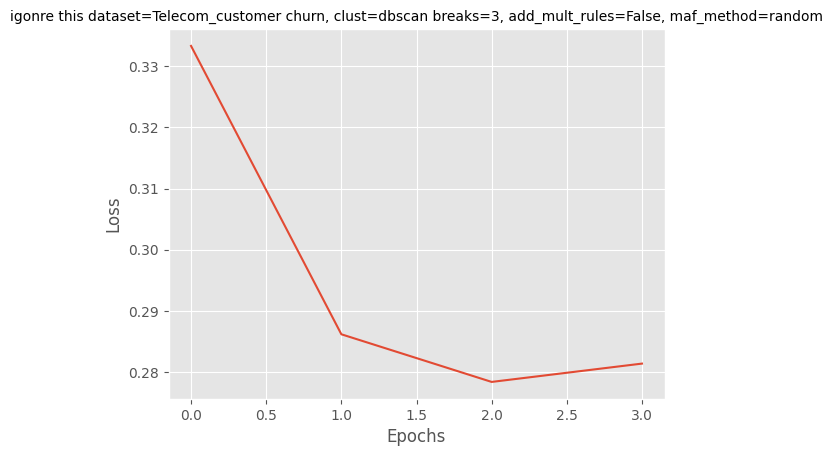

24-04-27 20:00:00 [DEBUG] Accuracy:  0.51
24-04-27 20:00:00 [DEBUG] F1 Score: 0.63
24-04-27 20:00:00 [DEBUG] Confusion Matrix: 
[[ 37 209]
 [ 20 197]]
24-04-27 20:00:00 [INFO] ------------------------------


In [18]:
num_breaks = 3
mult_rules = False
debug_mode = True
print_final_model = True
num_workers = 0

RULE_FOLDER = "rules_saved_clean"

ignore_for_training = ["labels_clustering", "distance_norm"]
df_cols = [i for i in list(data.columns) if i not in ignore_for_training]

rows_use = None
if rows_use:
    train_data_df_use = train_data_df.head(rows_use)
    X_train_use = X_train[:rows_use]
    y_train_use = y_train[:rows_use]
else:
    train_data_df_use = train_data_df
    X_train_use = X_train
    y_train_use = y_train
logger.debug(f"Train: {len(X_train_use)}")
for method in ["clustering", "random"]:
    name = f"igonre this dataset={dataset_name}, clust={CLUSTERING_ALG} breaks={num_breaks}, add_mult_rules={mult_rules}, maf_method={method}"
    logger.info(f"Step 5: Run DST ({name})")
    DSC = DSClassifierMultiQ(2, debug_mode=debug_mode, num_workers=num_workers, maf_method=method,
                            data=train_data_df_use, precompute_rules=True, )#.head(rows_use))
    logger.debug(f"\tModel init done")    
    res = DSC.fit(X_train_use, y_train_use, 
            add_single_rules=True, single_rules_breaks=num_breaks, add_mult_rules=mult_rules,
            column_names=df_cols, print_every_epochs=1, print_final_model=print_final_model)
    losses, epoch, dt = res
    logger.debug(f"\tModel fit done")

    DSC.model.save_rules_bin(os.path.join(RULE_FOLDER, f"{name}.dsb"))
#     most_important_rules = DSC.model.find_most_important_rules()
#     print(most_important_rules)
    DSC.model.print_most_important_rules()
    y_pred = DSC.predict(X_test)

    logger.info(f"Step 6: Inference done")

    report_results(y_test, y_pred, dataset=dataset_name, method=method,
                epoch=epoch, dt=dt, losses=losses, 
                save_results=True, name=name, print_results=True,
                breaks=num_breaks, mult_rules=mult_rules)
    
    logging.info("-"*30)
    
    

In [51]:
filter_by_rule(train_data_df_use, lambda x: x["rev_Mean"] < 32.278, print_results=True)

24-04-27 19:58:28 [DEBUG] Number of data points left after filtering: 262
24-04-27 19:58:28 [DEBUG] Number of clusters left after filtering: 2
24-04-27 19:58:28 [DEBUG] Most common cluster: 1
24-04-27 19:58:28 [DEBUG] Data points belong to different clusters
24-04-27 19:58:28 [DEBUG] Confidence: 0.21651189312479646
24-04-27 19:58:28 [DEBUG] Confidence after lowering based on proportion: 0.5364860436425323


(0.2317569781787339, 0.5364860436425323, 0.2317569781787339)

AttributeError: 'Axes' object has no attribute 'isna'

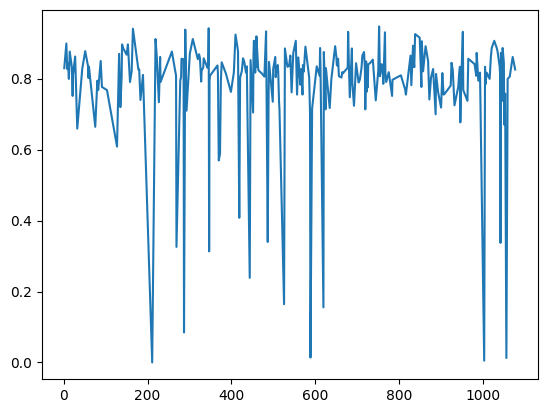

In [45]:
train_data_df_use.query("rev_Mean < 32.278").distance_norm.plot().isna().sum()

In [33]:
experiments = pd.read_csv("experiments.csv")

experiments.tail(2)

,name,accuracy,f1,confusion_matrix,training_time,epochs,min_loss,datetime,MAF method,dataset,breaks,mult_rules
84,"dataset=Brain Tumor, breaks=3, add_mult_rules=...",0.975199,0.970833,[[635 9]\n [ 19 466]],288.094734,69,0.033078,26-04-2024 21:24:14,kmeans,Brain Tumor,3.0,False
85,"dataset=Brain Tumor, breaks=3, add_mult_rules=...",0.982285,0.979339,[[635 9]\n [ 11 474]],394.811531,137,0.026403,26-04-2024 21:30:50,random,Brain Tumor,3.0,False


## Rules

In [34]:
RULE_FOLDER = "rules_saved_clean"

assert os.path.exists(RULE_FOLDER), f"Folder {RULE_FOLDER} does not exist"

rules = os.listdir(RULE_FOLDER)
logging.info(f"Found {len(rules)} rules")

24-04-26 21:41:45 [INFO] Found 4 rules


In [35]:
def get_pairs(rules):
    pairs = []
    for rule1 in rules:
        if 'maf_method' in rule1:
            for rule2 in rules:
                if rule1 == rule2 or (rule2, rule1) in pairs:
                    continue
                if rule2.startswith(rule1.split('maf_method')[0]):
                    pairs.append((rule1, rule2))
    return pairs

In [36]:
def extract_res(rules_info):
    rules = rules_info["preds"]
    mafs = rules_info["masses"]
    
    rule_names = [str(i) for i in rules]
    mass_first = [float(i[0]) for i in mafs]
    mass_second = [float(i[1]) for i in mafs]
    uncertainty = [float(i[2]) for i in mafs]
    
    res = {"rule": rule_names, "mass_first": mass_first, "mass_second": mass_second, "uncertainty": uncertainty}
    return res

In [39]:
pairs = get_pairs(rules)

dfs = {}

for r1, r2 in pairs:
    r1_info = pickle.load(open(os.path.join(RULE_FOLDER, r1), "rb"))
    r2_info = pickle.load(open(os.path.join(RULE_FOLDER, r2), "rb"))
    
    r1_df = pd.DataFrame(extract_res(r1_info))
    r2_df = pd.DataFrame(extract_res(r2_info))
    
    
    merged = pd.merge(r1_df, r2_df, on="rule", suffixes=('_kmeans', '_random'))
    merged.to_csv(f"rules_{r1}_{r2}.csv", index=False)

    print(f"Num rules {len(merged)}")
    fig = px.bar(merged, x='rule', y=['uncertainty_kmeans', 'uncertainty_random'], 
        title='Uncertainty comparison between kmeans and random', # put bars next to each other
        barmode='group')
    fig.write_html(f"{r1}_{r2}.html")
    dfs[r1] = merged 
    fig.show()

Num rules 49


Num rules 205


In [55]:
ks = list(dfs.keys())
print(ks)
a = dfs[ks[1]]


a["Uncertainty ratio"]  = a["uncertainty_random"] / a["uncertainty_kmeans"]

# remove inf
res = a["Uncertainty ratio"] 
res.replace([np.inf, -np.inf, ""], np.nan, inplace=True)

res = a["Uncertainty ratio"].dropna()

res.describe().round(3).to_clipboard()

['dataset=Brain Tumor, breaks=3, add_mult_rules=False, maf_method=kmeans.dsb', 'dataset=Brain Tumor, breaks=3, add_mult_rules=True, maf_method=kmeans.dsb']


In [47]:
a["Uncertainty ratio"].dropna()

0      1.950997
1      2.039998
2      2.296427
3      5.962318
4      2.055425
5      2.271974
6      2.257644
7      2.475599
8      2.068167
9      2.035401
10     2.328404
11     2.335880
12          inf
13     2.287148
14     1.489149
15     1.555324
16     1.407726
17     2.373192
18     2.151206
19     1.607796
20     0.800000
21     2.002392
22     2.090169
23     1.189022
24     2.078127
25     2.271453
26    11.785043
27     2.108319
28          inf
29    81.841992
30     1.546927
31     1.712679
32          inf
33     2.370462
34     1.966143
35     1.921688
36          inf
37     1.557658
38     1.915628
39     1.645202
40     2.094582
41     2.243877
42     2.615344
43     1.885207
44     2.361644
45     2.370196
46     1.955638
47     2.339852
48     5.545559
Name: Uncertainty ratio, dtype: float64

In [31]:

print(f"Num rules {len(merged)}")

Num rules 205


In [71]:
px.bar(merged, x='rule', y=['uncertainty_kmeans', 'uncertainty_random'], 
       title='Uncertainty comparison between kmeans and random', # put bars next to each other
       barmode='group')